In [1]:
import os
import matplotlib.pyplot as plt
import argparse
import numpy as np

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, Flatten, Reshape, Add, Concatenate, MaxPool2D
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras import backend as K

from model.unet import unet
from model.fcn import fcn_8s
from model.pspnet import pspnet50
from dataset_parser import generator_dirty, generator_coarse, generator

%load_ext autoreload
%autoreload 2

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)
lr_init = 1e-4
lr_decay = 5e-4
vgg_path = None
model_name = "fcn_coarse"

# Use only 3 classes.
labels = ['background', 'person', 'car', 'road']


model = fcn_8s(input_shape=(256, 512, 3), num_classes=len(labels),
               lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)

In [3]:
checkpoint = ModelCheckpoint(filepath=model_name + '_model_weight.h5',
                             monitor='val_dice_coef',
                             save_best_only=True,
                             save_weights_only=True)

### Train on Coarse

In [4]:
model.load_weights('fcn_coarse_model_weight.h5')

In [6]:
# history = model.fit_generator(generator_coarse.data_generator('dataset_parser/data-coarse.h5', TRAIN_BATCH, 'train_extra'),
#                               steps_per_epoch= 5000 // TRAIN_BATCH,
#                               validation_data=generator_dirty.data_generator('dataset_parser/data-dirty.h5', VAL_BATCH, 'val'),
#                               validation_steps=500 // VAL_BATCH,
#                               callbacks=[checkpoint],
#                               epochs=3,
#                               verbose=1)

Epoch 1/3
1250/1250 [==============================] - 514s 412ms/step - loss: 0.4465 - dice_coef: 0.7112 - val_loss: 0.4483 - val_dice_coef: 0.7223
Epoch 2/3
1250/1250 [==============================] - 496s 397ms/step - loss: 0.3279 - dice_coef: 0.7762 - val_loss: 0.3745 - val_dice_coef: 0.7619
Epoch 3/3
1250/1250 [==============================] - 492s 393ms/step - loss: 0.2810 - dice_coef: 0.8064 - val_loss: 0.3618 - val_dice_coef: 0.7810


# View the Corresponding Fine and Coarse Images and Predictions

In [5]:
coarse_generator = generator_coarse.data_generator('dataset_parser/data-coarse.h5', 10, 'train')
fine_generator = generator.data_generator('dataset_parser/data.h5', 10, 'train')

2975
2975


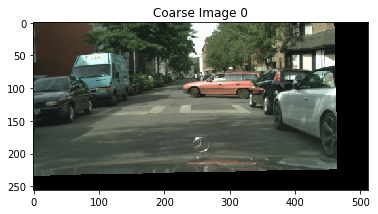

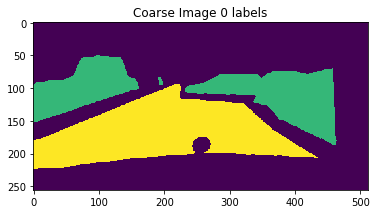

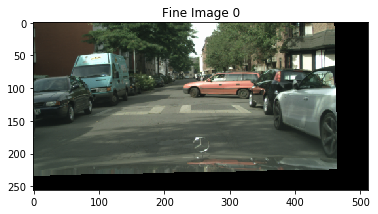

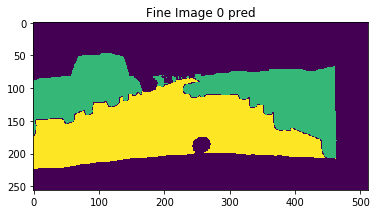

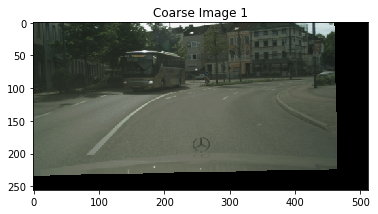

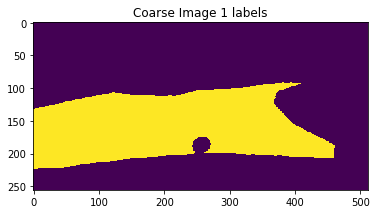

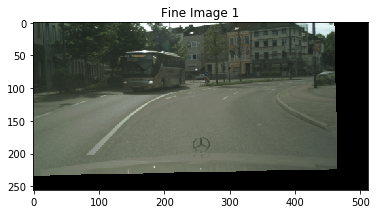

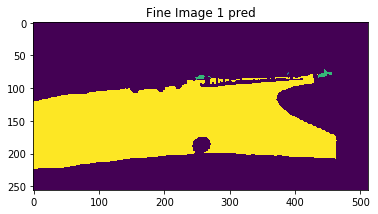

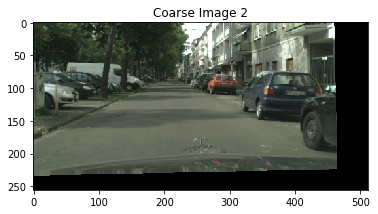

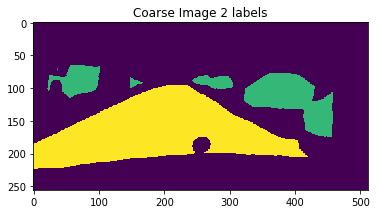

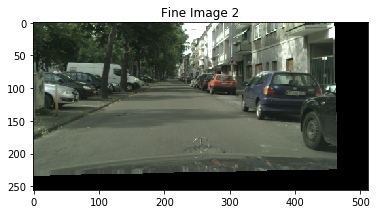

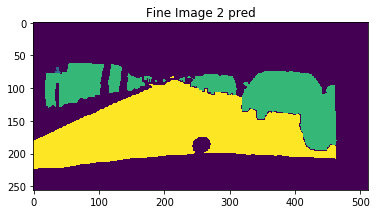

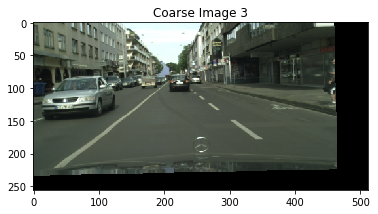

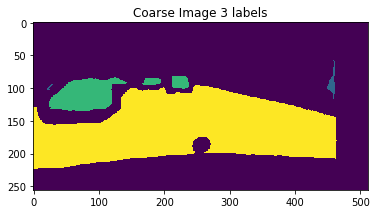

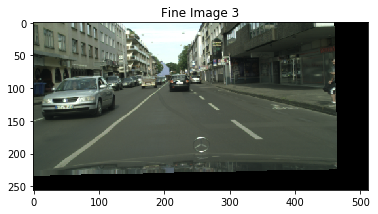

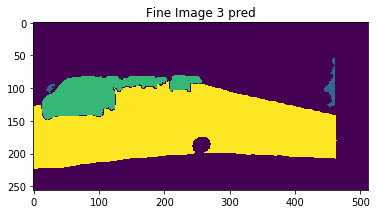

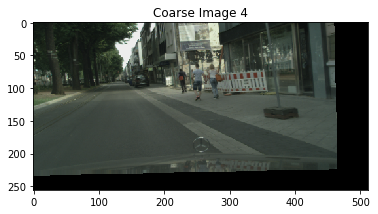

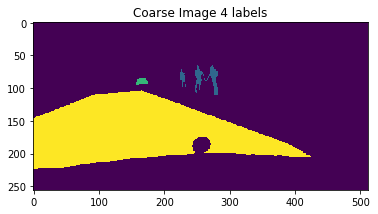

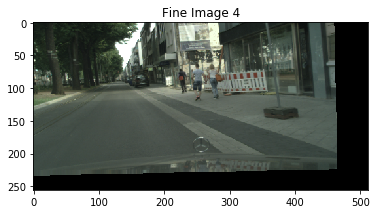

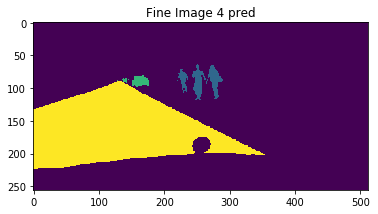

In [6]:
for i in range(5):
    x, y = next(coarse_generator)
    x_, y_ = next(fine_generator)

    orig_shaded_image = (x[0] + 1)/2
    plt.figure()
    plt.imshow(orig_shaded_image)
    plt.title('Coarse Image {}'.format(i))    
    
    label_shaded_image = np.argmax(y[0], axis=-1)
    plt.figure()
    plt.imshow(label_shaded_image)
    plt.title('Coarse Image {} labels'.format(i))
    
    orig_shaded_image = (x_[0] + 1)/2
    plt.figure()
    plt.imshow(orig_shaded_image)
    plt.title('Fine Image {}'.format(i))        
    
    label_shaded_pred = np.argmax(y_[0], axis=-1)        
    plt.figure()
    plt.imshow(label_shaded_pred)    
    plt.title('Fine Image {} pred'.format(i))

# Error Correction (New Architecture)

In [7]:
lr_init = 1e-3
lr_decay = 5e-4
window_size = 30

inp_y = Input(shape=(window_size, window_size, 4))
inp_x = Input(shape=(window_size, window_size, 3))
h = Concatenate()([inp_y, inp_x])
h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
h = MaxPool2D((2, 2), padding='same')(h)
h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
h = MaxPool2D((2, 2), padding='same')(h)
h = Conv2D(16, (4, 4), padding='same', activation='relu')(h)
h = Flatten()(h)
h = Dense(40, activation='relu')(h)
h = Dense(4, activation='softmax')(h)
ec_model = Model(inputs=[inp_y, inp_x], outputs=h)

ec_model.summary()
ec_model.compile(optimizer=Adam(lr=lr_init, decay=lr_decay),
                 loss='categorical_crossentropy', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 30, 30, 4)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 30, 30, 3)    0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 30, 30, 7)    0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 30, 30, 8)    904         concatenate_1[0][0]              
__________

In [8]:
coarse_generator = generator_coarse.data_generator('dataset_parser/data-coarse.h5', 10, 'train')
fine_generator = generator.data_generator('dataset_parser/data.h5', 10, 'train')

skip = 3
batch_size = 128
half_window = window_size//2

count_diff = 0
metrics = None

inp_x = list()
inp_y = list()
out = list()

for i in range(120):
    x_, y_ = next(coarse_generator)
    x, y = next(fine_generator)
    
    for r in range(0, x.shape[1] - window_size, skip):
        for c in range(0, x.shape[2] - window_size, skip):
            for j in range(y.shape[0]):
                if np.argmax(y[j, r+half_window, c+half_window, :]) == np.argmax(y_[j, r+half_window, c+half_window, :]):
                    if count_diff > 0:
                        count_diff -= 1
                        inp_x.append(x[j, r: r+window_size, c: c+window_size, :])
                        inp_y.append(y_[j, r: r+window_size, c: c+window_size, :])
                        out.append(y[j, r+half_window, c+half_window, :])
                else:
                    count_diff += 1
                    inp_x.append(x[j, r: r+window_size, c: c+window_size, :])
                    inp_y.append(y_[j, r: r+window_size, c: c+window_size, :])
                    out.append(y[j, r+half_window, c+half_window, :])

        if len(out) > batch_size:
            metrics = ec_model.train_on_batch([np.stack(inp_y), np.stack(inp_x)], np.stack(out))
            print(i, r, c, len(out), metrics)            
            inp_x = list()
            inp_y = list()
            out = list()
    
    model.save('error-correcting-model-type2.h5')

2975
2975
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0 42 480 134 [1.3584173, 0.40298507]
0 51 480 218 [1.2391332, 0.82568806]
0 57 480 240 [1.1292442, 0.5375]
0 60 480 132 [1.0149235, 0.49242425]
0 63 480 152 [0.9454685, 0.5065789]
0 66 480 132 [0.82716364, 0.5681818]
0 69 480 164 [0.84254485, 0.597561]
0 72 480 174 [0.9157547, 0.5632184]
0 75 480 180 [1.1754357, 0.55]
0 78 480 226 [1.2313305, 0.53539824]
0 81 480 278 [1.1511334, 0.5755396]
0 84 480 276 [1.26478, 0.4746377]
0 87 480 300 [1.1341288, 0.51]
0 90 480 310 [1.054225, 0.5258064]
0 93 480 266 [1.0391338, 0.5112782]
0 96 480 326 [1.1164927, 0.48773006]
0 99 480 442 [1.1340686, 0.43438914]
0 102 480 454 [1.0875576, 0.48678413]
0 105 480 526 [1.1027507, 0.45057034]
0 108 480 526 [1.1233785, 0.4543726]
0 111 480 596 [1.1123344, 0.42449665]
0 114 480 636 [1.0888655, 0.4072327]
0 117 480 614 [1.0864009, 0.38110748]
0 120 480 580 [1.0664277, 0.4275862]
0 123 480 530 [1.0759453, 0.

KeyboardInterrupt: 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

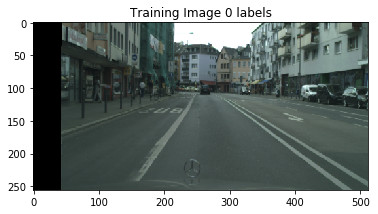

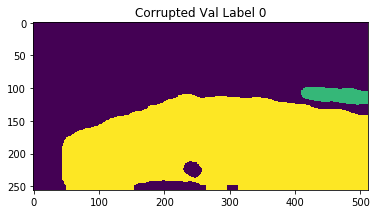

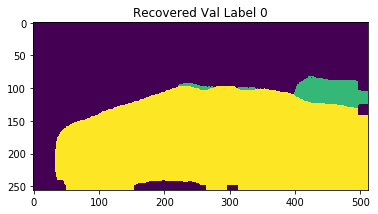

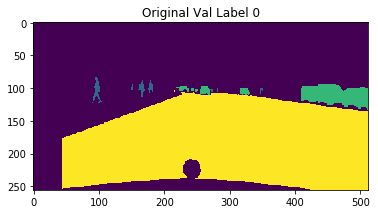

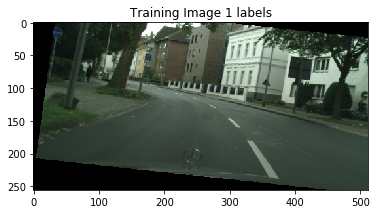

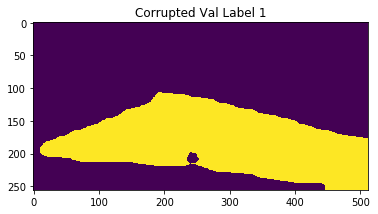

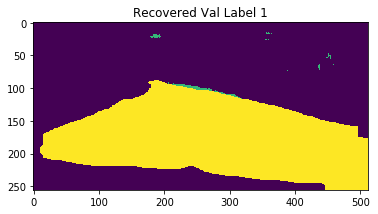

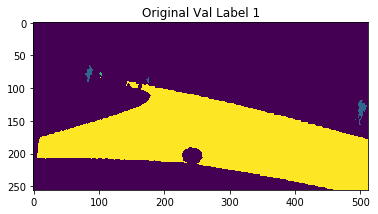

In [9]:
generator = generator_dirty.data_generator('dataset_parser/data-dirty.h5', 4, 'val', dirty=False)

x_batch, y_batch = next(generator)
y_batch_ = model.predict(x_batch)

for i in range(2):
    x = x_batch[i]
    y = y_batch[i]
    y_ = y_batch_[i]
    
    y_recon = np.copy(y_)

    orig_shaded_image = (x + 1)/2
    plt.figure()
    plt.imshow(orig_shaded_image)
    plt.title('Training Image {} labels'.format(i))        

#     for r in range(0, x.shape[0]):
#         print(r, end=' ')
#         for c in range(0, x.shape[1]):
#             if r < half_window or r >= x.shape[0] - half_window or c < half_window or c >= x.shape[1] - half_window:
#                 out = y_[r, c]
#             else:
#                 inp_x = np.expand_dims(x[r-half_window: r+half_window, c-half_window: c+half_window, :], 0)
#                 inp_y = np.expand_dims(y_[r-half_window: r+half_window, c-half_window: c+half_window, :], 0)
#                 out  = ec_model.predict([inp_y, inp_x])
#             y_recon[r, c] = out

    for r in range(0, x.shape[0]):
        print(r, end=' ')
        inp_x = []
        inp_y = []
        for c in range(0, x.shape[1]):
            if r < half_window or r >= x.shape[0] - half_window or c < half_window or c >= x.shape[1] - half_window:
                out = y_[r, c]
            else:
                inp_x.append(x[r-half_window: r+half_window, c-half_window: c+half_window, :])
                inp_y.append(y_[r-half_window: r+half_window, c-half_window: c+half_window, :])
        if len(inp_x) > 0:
            out  = ec_model.predict([np.stack(inp_y), np.stack(inp_x)])
            y_recon[r, half_window: x.shape[1]-half_window] = out
            
    plt.figure()
    plt.imshow(np.argmax(y_, axis=-1))
    plt.title('Corrupted Val Label {}'.format(i))    

    plt.figure()
    plt.imshow(np.argmax(y_recon, axis=-1))
    plt.title('Recovered Val Label {}'.format(i))

    plt.figure()
    plt.imshow(np.argmax(y, axis=-1))    
    plt.title('Original Val Label {}'.format(i))

# Train on ECN-corrected Data

In [10]:
generator = data_generator('dataset_parser/data-dirty.h5', 4, 'train', dirty=True)

num_clean_batches = int(0.9 * 3475 / 4)
num_epochs = 5

for i in range(num_clean * num_epochs):
    x, y = next(generator)
    row_index_input1 = np.zeros((y.shape[0], y.shape[1], y.shape[2], 1))
    row_index_input2 = np.zeros((y.shape[0], y.shape[1], y.shape[2], 1))
    for j in range(row_index_input1.shape[1]):
        row_index_input1[:, j, :] = j / row_index_input1.shape[1]
        row_index_input2[:, j, :] = 1 - (j / row_index_input1.shape[1])
    row_inp = np.concatenate((row_index_input1, row_index_input2), axis=-1)
    y_corrected = ec_model.predict([y, row_inp, x])
    
    metrics = model.train_on_batch(x, y_corrected)
    print(i, metrics)

0 [4.65622, 1.1115892]
1 [4.198523, 1.1284161]
2 [2.6988237, 1.2436295]
3 [2.672761, 1.2501549]
4 [2.9889405, 1.2248052]
5 [2.6735249, 1.2316834]
6 [2.7623897, 1.2758715]
7 [2.5750618, 1.2634934]
8 [2.755848, 1.3011453]
9 [2.390698, 1.3165307]
10 [2.419078, 1.3257194]
11 [2.070889, 1.3868371]
12 [2.7323875, 1.3368143]
13 [2.577635, 1.3412404]
14 [2.0107768, 1.3697147]
15 [2.2929828, 1.37269]
16 [2.2454271, 1.3485931]
17 [2.089726, 1.3700134]
18 [2.709905, 1.3124254]
19 [2.0725145, 1.3757029]
20 [2.3743255, 1.3577815]
21 [1.9989265, 1.3957477]
22 [2.0903044, 1.3523949]
23 [2.2712526, 1.3633045]
24 [2.0579581, 1.3763697]
25 [2.3254278, 1.3494425]
26 [2.1056013, 1.3546656]
27 [2.1612964, 1.3563787]
28 [2.0843718, 1.3379341]
29 [2.0224133, 1.3729473]
30 [2.1529055, 1.3786098]
31 [2.0217228, 1.356305]
32 [2.1680503, 1.3523016]
33 [2.087822, 1.3592439]
34 [2.0905733, 1.4033062]
35 [2.1615841, 1.3672153]
36 [2.3089218, 1.380187]
37 [2.215805, 1.3517202]
38 [2.0983324, 1.3715296]
39 [1.9527528

KeyboardInterrupt: 